In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
using LinearAlgebra, Plots
import Convex as cvx 
import MeshCat as mc 
using Test
using Random
import Convex as cvx 
import ForwardDiff as FD
import ECOS      
using Random


  Activating environment at `~/CMU/16-745 Optimal Control/HEXROTOR_MODELING/Project.toml`


In [72]:
#include(joinpath(@__DIR__,"ref_traj.jl"))
#include(joinpath(@__DIR__,"planar_hexrotor_dynamics.jl"))
include(joinpath(@__DIR__,"tilted_hexrotor_dynamics.jl"))


animate_hexrotor (generic function with 1 method)

In [67]:
function create_ref_hover(model, N, dt, n_inputs)
    # create a hover reference (with no pitch) for whole time period
    mass = model.mass
    kf = model.kf

    # hover altitude
    desired_altitude= 1

    # hover state
    hover_position = [0.0; 0.0; desired_altitude]  # Hover at (0, 0, 5)
    hover_velocity = [0.0; 0.0; 0.0]  # no velocity
    hover_attitude = [0.0; 0.0; 0.0]  # No roll, pitch, yaw
    hover_angvelocity= [0.0; 0.0; 0.0] # no angular velocity
    
    Xref= [zeros(12) for i = 1:N]
    for i= 1:N
        Xref[i]= [hover_position; hover_velocity; hover_attitude; hover_angvelocity]
    end

    #Uref = [(9.81*mass/(n_inputs*kf))*ones(n_inputs) for i = 1:(N-1)]
    Uref = [(9.81*mass/n_inputs)*ones(n_inputs) for i = 1:(N-1)]
    return Xref, Uref
end

# converting to and from vector of vectors <-> matrix 
function mat_from_vec(X::Vector{Vector{Float64}})::Matrix
    # convert a vector of vectors to a matrix 
    Xm = hcat(X...)
    return Xm 
end

mat_from_vec (generic function with 1 method)

In [73]:

# Drone parameters
Ixx= 2.331e2
Iyy= 2.322e2
Izz= 4.022e2
model = (mass= 6.728,
    J= Diagonal([Ixx, Iyy, Izz]), 
    gravity= [0,0,-9.81],
    L= 0.5375, 
    kf= 0.1, # constant thrust coefficient 
    km= 0.01, # propeller drag coefficient
    dt= 0.1, #, # 100 horizon
    α= 0.49, #rad
    β= 0.33 # rad
)

# states and controls 
nx = 12 
nu = 6

# problem size 
dt = model.dt
tf = 200
t_vec = 0:dt:tf
N = length(t_vec)

# Generate hover trajectory for hexrotor

# initial condition of zeros
x0= [0.0, 0.0, 1.0, 0.0, 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
xg= [0.0, 0.0, 1.0, 0.0, 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
X_ref, U_ref = create_ref_hover(model, N, dt, nu)

X_= X_ref[1]
#X_= [ForwardDiff.Dual(x, 1.0) for x in X__]
U_= U_ref[1]
#U_= [ForwardDiff.Dual(u, 1.0) for u in U__]

# cost terms 
Q = diagm(ones(nx))*10
Qf = 10*Q
R = 0.001*diagm(ones(nu))



# calculate A and B matrices (jacobians of discrete dynamics with respect to X and U)
A= FD.jacobian(dx -> rk4(model, hexrotor_dynamics, dx, U_, dt), X_)
B= FD.jacobian(du -> rk4(model, hexrotor_dynamics, X_, du, dt), U_)



# infinite horizon LQR
Kinf= B'
max_iters= 1e6
P= deepcopy(Q) #initialize p
for i= 1:max_iters
    Kinf = (R .+ B' * P * B)\  (B' * P * A)
    P_recursion = Q + A' * P * A - A' * P * B * Kinf
    
    if norm(P-P_recursion) <= 1e-6
        break
    end
    # update P for next iteration
    P = 1*P_recursion
end


In [74]:
Random.seed!(1) 

Δx = [zeros(nx) for i = 1:N]
Δu = [zeros(nu) for i = 1:N-1]

X= [zeros(nx) for i = 1:N]
U= [zeros(nu) for i = 1:N-1]

# at umin, umax of +/- 75, start to see the clamping effect (with noise at 0.01 scale)
#u_min= -200, -150, -100
#u_max= 200, 150, 100
#u_min= -30 # bad
#u_max= 30 #bad
# at 35-40, starts to drive the xy position out more because clamping down on the initial 
u_min= -75
u_max= 75


Δx[1]= x0- X_ + 0.01* rand(nx) # add a little bit of noise...
#simulate this controlled system with rk4(params_real, ...)
for i = 1:N-1
    
    if i < 10 # can make this much longer with this dynamics model! 
        Δu[i] = clamp.(-Kinf * (Δx[i]) .+0.01*randn(nu), u_min, u_max)
        Δx[i+1]= A*(Δx[i]) + B*(Δu[i]) .+ 0.01*randn(nx)
    else
        Δu[i] = clamp.(-Kinf * (Δx[i]), u_min, u_max) #+0.001*randn(nu)
        Δx[i+1]= A*(Δx[i]) + B*(Δu[i]) #.+ 0.001*randn(nx)
    end
    
    # check absolutes
    X[i]= Δx[i] + X_
    U[i]= Δu[i] + U_
end

X[N]= Δx[N] +X_;


# check for stability
eig= abs.(eigvals(A- B*Kinf))

# Check if all eigenvalues are less than 1
if all(x -> x < 1.0, eig)
    println("The system is stable.")
else
    println("The system is unstable.")
end

The system is stable.


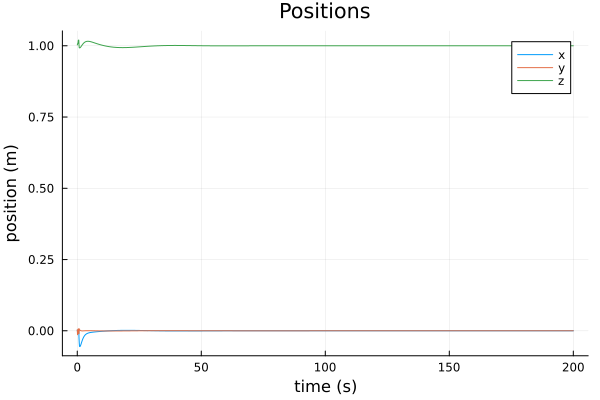

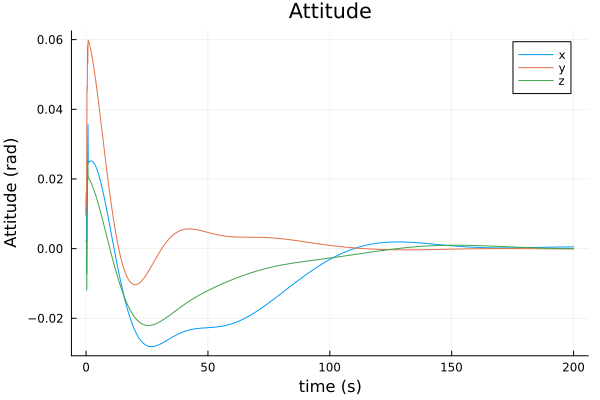

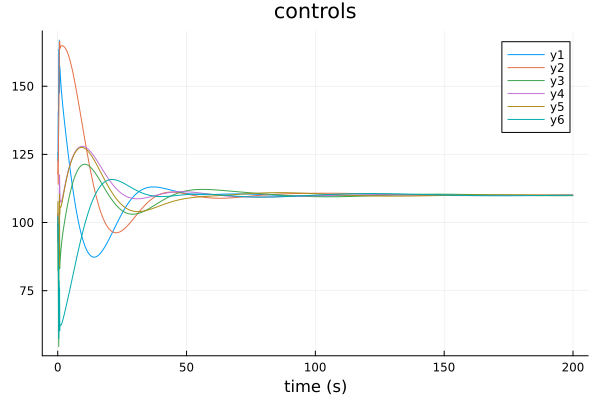

┌ Info: Listening on: 127.0.0.1:8714, thread id: 1
└ @ HTTP.Servers /Users/ashleykline/.julia/packages/HTTP/vnQzp/src/Servers.jl:382
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8714
└ @ MeshCat /Users/ashleykline/.julia/packages/MeshCat/QXID5/src/visualizer.jl:64


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("drone" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x68, 0x63, 0x61, 0x74, 0x2f, 0x64, 0x72, 0x6f, 0x6e, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("base" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x64, 0x72, 0x6f, 0x6e, 0x65, 0x2f, 0x62, 0x61, 0x73, 0x65], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x64, 0x72, 0x6f, 0x6e, 0x65, 0x2f, 0x62, 0x61, 0x73, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8714, HTTP.Servers.Server{HTTP.Servers.Listener{Nothing, Sockets.TCPServer}}(HTTP.Servers.Listener{Nothing, Sockets.TCPServer}(Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 8714), "127.0.0.1", "8714", nothing, Sockets.TCPServer(RawFD(58) active)), nothing, Set{HTTP.Connections.Connection}(), Task (runnable) @0x000000019dbf1110, ReentrantLock(nothing, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), 0))))

In [75]:
# ### plotting
# Xm = hcat(X...)
# plot(t_vec, Xm[1:3,:]')
# Xbarm = hcat(X_ref...)
# plot!(t_vec,Xbarm[1:3,:]',ls=:dash)
# #display(plot!(t_vec,))

# Xm = hcat(Δx...)
# display(plot(t_vec, Xm[1:3,:]'))
# Um= hcat(Δu...)
# display(plot(t_vec[1:end-1],Um[1:3,:]',ls=:dash))
# #display(plot!(t_vec,))


# Xm = hcat(X...)
# display(plot(t_vec, Xm[1:3,:]'))
# Um= hcat(U...)
# display(plot(t_vec[1:end-1],Um[1:3,:]',ls=:dash))
# #LQR cost to go would be the cost in MPC, should exactly match LQR
# #display(animate_hexrotor(Xsim, Xref, model.dt))

    # -------------plotting/animation---------------------------
    Xm = mat_from_vec(X)
    Um = mat_from_vec(U)
    display(plot(t_vec,Xm[1:3,:]',title = "Positions",
            xlabel = "time (s)", ylabel = "position (m)",
            label = ["x" "y" "z"]))
    display(plot(t_vec,Xm[7:9,:]',title = "Attitude",
            xlabel = "time (s)", ylabel = "Attitude (rad)",
            label = ["x" "y" "z"]))
    display(plot(t_vec[1:end-1],Um',title = "controls",
            xlabel = "time (s)"))  


display(animate_hexrotor(X, dt))